In [5]:
"""
Demo showing how km_dict and insegtprobannotator may be used together for
interactive segmentation. 

@author: vand and abda
"""

import sys
import skimage.io
import skimage.data
import numpy as np
%gui qt
patch_dir = '../'
import sys
if patch_dir not in sys.path:
    sys.path.append(patch_dir)
import insegtprobannotator
import km_dict
import feat_seg
import PyQt5.QtCore 

import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib notebook



In [6]:
#%% EXAMPLE 2: nerve fibres

## loading image
print('Loading image')
data_path = '../../data'
filename = data_path + '/nerve_im_scale.png'
image = skimage.io.imread(filename)


Loading image


In [7]:
int_patch_size = 9
branching_factor = 5
number_layers = 5
number_training_patches = 200000
normalization = False

patch_size_feat = 5
n_train = 50000
n_keep = 25
order_keep = (True, True, True)

image_float = image.astype(np.float)/255

# Compute feature image
feat_im, vec, mean_patch, norm_fac = feat_seg.get_uni_pca_feat(image_float, patch_size_feat, n_train, n_keep, order_keep, sigma = -1)
feat_im = np.asarray(feat_im.transpose(2,0,1), order='C')

# Build tree
T = km_dict.build_km_tree(feat_im, 1, branching_factor, number_training_patches, number_layers, normalization)

# Search km-tree and get assignment
A, number_nodes = km_dict.search_km_tree(feat_im, T, branching_factor, normalization)
# number of repetitions for updating the segmentation
number_repetitions = 2


def processing_function(labels):
    r,c = labels.shape
    l = np.max(labels)+1
    if(l>1):
        label_image = np.zeros((r,c,l))
        for k in range(number_repetitions):
            for i in range(1,l):
                label_image[:,:,i] = (labels == i).astype(float)
            D = km_dict.improb_to_dictprob(A, label_image[:,:,1:], number_nodes, int_patch_size) # Dictionary
            P = km_dict.dictprob_to_improb(A, D, int_patch_size) # Probability map
            labels = (np.argmax(P,axis=2) + 1)*(np.sum(P,axis=2)>0)# Segmentation
    else:
        P = np.empty((r,c,0))
        D = None
    return labels, P.transpose(2,0,1), D

pf = lambda labels: processing_function(labels)[:2]

print('Showtime')    

# showtime
app = PyQt5.QtCore.QCoreApplication.instance()
if app is None:
    app = insegtprobannotator.PyQt5.QtWidgets.QApplication(sys.argv)
ex = insegtprobannotator.InSegtProbAnnotator(image, pf)
app.exec_()

number of training patches 114244
Showtime
Starting InSegt annotator. For help, hit 'H'.


0

<IPython.core.display.Javascript object>


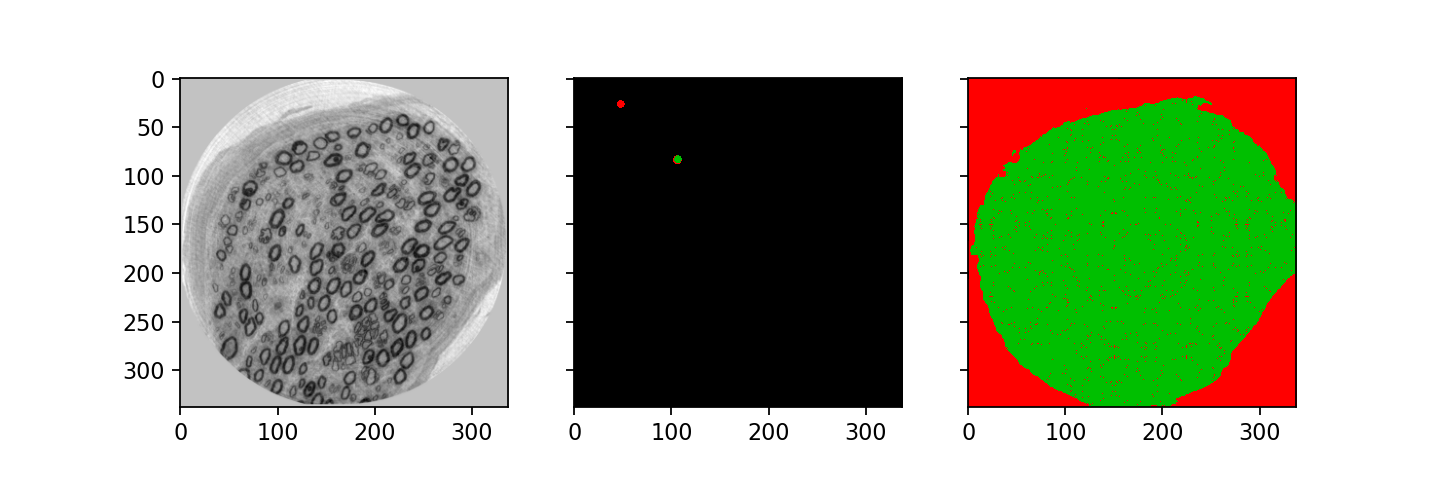

In [8]:
labels = ex.rgbaToLabels(ex.pixmapToArray(ex.annotationPix))

segmentation, P, D = processing_function(labels)

colors = np.asarray(ex.colors)/255
cm = matplotlib.colors.LinearSegmentedColormap.from_list('insegt_colors', colors, N=len(ex.colors))

l = int(D.shape[1]/(int_patch_size**2))
fig,ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,3))
ax[0].imshow(image, cmap = 'gray')
ax[1].imshow(labels, vmin = 0, vmax = len(ex.colors), cmap = cm)
ax[2].imshow(segmentation, vmin = 0, vmax = len(ex.colors), cmap = cm)
plt.show()


In [ ]:
# Probabilities
n_p = len(P)
n_cols = 3
n_rows = int(np.ceil(n_p/n_cols))

print(f'n_p {n_p} n_cols {n_cols} n_rows {n_rows}')
fig,ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(9,3*n_rows))
ax = ax.ravel()
for i in range(0,n_rows*n_cols):
    if ( i < n_p ):
        ax[i].imshow(P[i], cmap = 'jet')
    else:
        ax[i].axis('off')
plt.show()




In [ ]:
# Dictionary
fig,ax = plt.subplots(1, figsize=(5,3))
ax.imshow(D, aspect='auto', cmap = 'jet')
plt.show()